In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import erfc
from PIL import Image as im 
from matplotlib import animation, rc
plt.rc('animation', html='jshtml')
from IPython.display import HTML
import subprocess as sp
import sys,math

import matplotlib.font_manager
from IPython.core.display import HTML
def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)
code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])
HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [2]:
def trackPercent(place,totalLength,strLen): #percent output tracker
    percent = place/totalLength*10
    if math.floor(percent)==69:
        string="{:.2f} % complete -- nice".format(percent)
    else:
        string="{:.2f} % complete".format(percent)
    sys.stdout.write("\r") #this "moves the cursor" to the beginning of the I0 line
    sys.stdout.write(" "*strLen) #this "clears" whatever was on the line last time by writing whitespace
    sys.stdout.write("\r") #move the cursor back to the start again
    sys.stdout.write(string) #display the current percent we are at
    sys.stdout.flush() #flush finishes call to print() (this is like what's under the hood of print function)
    strLen=len(string) #return the new string length for next function call
    return strLen
#--NotebookApp.iopub_data_rate_limit=1.0e10

We will solve Stoke's 2nd problem: diffusion of heat through a solid object. Specifically, we want to study how the temperature inside a rotating asteroid changes as it receives heat from the Sun. The simplest equation to describe this problem is the 1D diffusion equation

## $\frac{\partial T}{\partial t} = \kappa \frac{\partial^{2} T}{\partial z^{2}} $,

where $\kappa$ is the diffusion coefficient, describing how quickly the heat transfer takes place. The temperature at the surface can be described as $ T(t, 0) = T_{0}cos(\omega t)$ and appropriate constants $\omega$ and $\kappa$ as well as appropriate boundary conditions can be chosen.

This one-dimensional heat equation is analytically solvable, so we can compare our numerical solutions to analytic ones. We also plan to add additional terms to explore more interesting physics, such as radiative losses or terms to describe an inhomogenous material. Furthermore, we will think about whether we could add a physically relevant convective term too.


## <center> Asteroid Data:
    
* Rotation rates typically 4-24 hr
* Diameters from 10m to 500km
    
    
https://canvas.colorado.edu/courses/64461/files/25494729?module_item_id=2409565

In [3]:
class pde_solver():
    def __init__(self,L, t_tot, T0, kappa, dz, omega):
    
    #'''
    #Solve the 1d diffusion equation using finite differences method, with inputs for the 
    #spatial range (L), total time (t), initial condition (T0), diffusion coeffecient 
    #(kappa), number of timesteps (Nt), number of spatial nodes (Nz), and frequency (omega)
    #'''
        self.L=L;
        self.t_tot=t_tot
        self.T0=T0
        self.kappa=kappa
        
        self.dz=dz
        self.dt=0.9*(self.dz**2/self.kappa)/2
        print(self.dt)
        self.omega=omega
        self.z = np.arange(0, self.L , self.dz) # Or dz = z[1] - z[0]
        self.Nz = len(self.z)
        self.t = np.arange(0, self.t_tot, self.dt) # How long do we want to let it go for? A few days?
        self.Nt = len(self.t)
        self.T_sol=None
        self.T=None
        self.T0_array=None
    # Define space and time arrays 
    def numerical(self):

        self.r = self.kappa*self.dt/(self.dz**2) # Diffusion condition
        print("Condition on step sizes: ", self.dt < (self.dz**2/self.kappa)/2)

        self.Tr=np.zeros((self.Nt, self.Nz+2))
        self.Tl=np.zeros_like(self.Tr)
        # Set initial condition 
        self.Tr[0,:] = 0
        self.Tl[0,:] = 0
        str_len = 0
        # Insert boundary conditions
        self.Tr[:,0] = self.T0*(np.sin(self.omega*self.t))
        self.T0_array = self.T0*(np.sin(self.omega*self.t))
        self.Tl[:,0] = self.T0*(np.sin(self.omega*self.t + np.pi))

        for i in range(1, self.Nt):

            # Compute u at inner mesh points for i in range(1, Nz):
            self.Tr[i,1:-1] =  self.Tr[i-1,1:-1] + self.r * (self.Tr[i-1,2:] - 2*self.Tr[i-1,1:-1] + self.Tr[i-1,:-2]) 
            self.Tl[i,1:-1] =  self.Tl[i-1,1:-1] + self.r * (self.Tl[i-1,2:] - 2*self.Tl[i-1,1:-1] + self.Tl[i-1,:-2])
            if float(10*int(i/10))==float(i):
                str_len = trackPercent(i,self.Nt/10,str_len)
                str_len += 1


        self.T = (self.T0+self.Tr[:,1:-1])+(self.T0+np.flip(self.Tl[:,1:-1],axis=1))
        #print("T, z shapes: ", T.shape, z.shape)
        #return self.T
    
    def analytic(self):
        t_a=self.t.reshape(self.Nt,1)
        z_a=self.z.reshape(1,self.Nz)
        self.k = np.sqrt(self.omega/(2*self.kappa))
        #self.T0*(np.sin(self.omega*t_a))*
        self.T_R = self.T0*(np.exp(-self.k*z_a)*(np.sin(self.k*z_a - self.omega*t_a)))+self.T0
        self.T_L=np.flip(self.T0*np.exp(-self.k*z_a)*(np.sin((self.k*z_a - self.omega*t_a)+np.pi))+self.T0,axis=1)
        self.T_sol=self.T_R+self.T_L
        self.func=np.exp(-self.k*z_a)*(np.sin(self.k*z_a - self.omega*t_a))
        #return self.T_sol
        


In [4]:
solve = pde_solver(L=50, t_tot=10000, T0=3, kappa=5, dz=0.8, omega=1e-3)
solve.numerical()
solve.analytic()
print(solve.Nt,solve.Nz)

0.05760000000000001
Condition on step sizes:  True
16.17 % complete 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



47.53 % complete 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



79.96 % complete         

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100.00 % complete173612 63


275.57460317460317


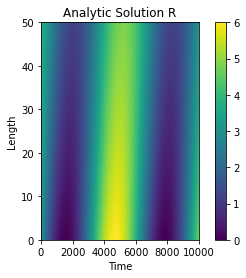

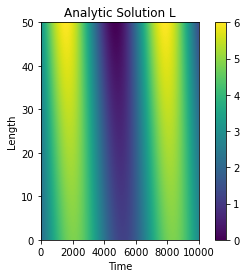

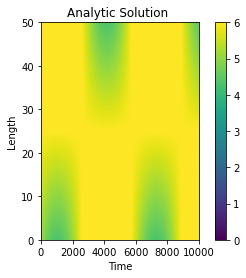

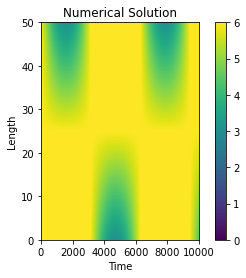

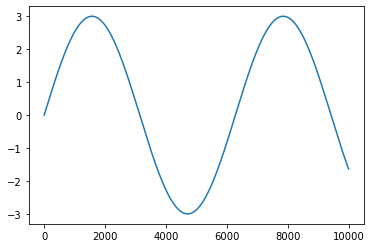

In [5]:
#L=1000
#plt.figure(figsize=(8,8))
ratio=0.1*solve.Nt/solve.Nz
print(ratio)
plt.imshow(solve.T_R.T,vmin=0,vmax=6, aspect=ratio,origin='lower',extent=(0,solve.t_tot,0,solve.L))
plt.ylabel('Length'); plt.xlabel('Time')
plt.title('Analytic Solution R',size=12)
plt.colorbar()
plt.show()

plt.imshow(solve.T_L.T,vmin=0,vmax=6, aspect=ratio,origin='lower',extent=(0,solve.t_tot,0,solve.L))
plt.ylabel('Length'); plt.xlabel('Time')
plt.title('Analytic Solution L',size=12)
plt.colorbar()
plt.show()
plt.imshow(solve.T_sol.T,vmin=0,vmax=6, aspect=ratio,origin='lower',extent=(0,solve.t_tot,0,solve.L))
plt.ylabel('Length'); plt.xlabel('Time')
plt.title('Analytic Solution ',size=12)
plt.colorbar()
plt.show()
#plt.figure(figsize=(8,8))
plt.imshow(solve.T.T,vmin=0,vmax=6,  aspect=ratio,origin='lower',extent=(0,solve.t_tot,0,solve.L))
plt.ylabel('Length'); plt.xlabel('Time')
plt.colorbar()
plt.title('Numerical Solution',size=12)
plt.show()

plt.plot(solve.t,solve.T0_array)

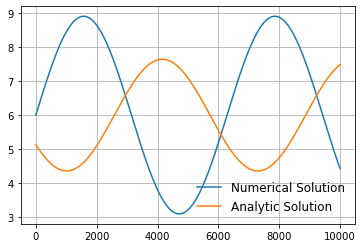

In [37]:
z0=0#int(len(solve.z)/5)
#plt.plot(solve.t,solve.T_R[:,z0],label='Analytic Solution R')#marker='o',size=20
#plt.plot(solve.t,solve.T_L[:,z0],label='Analytic Solution L')#marker='o',size=20
plt.plot(solve.t,solve.T[:,z0],label='Numerical Solution')
plt.plot(solve.t,solve.T_sol[:,z0],label='Analytic Solution')#marker='o',size=20
plt.legend(loc=0,ncol=1,prop={'size':12},frameon=False)
plt.grid()
plt.show()

## <center> What next:
    * Explore parameter space and understand what's happening
    * Compare analytic solution
    * Add new terms:
        * Radiative losses
        * Other physics?
    * Try implementing RK2?
        * Error analysis comparison
  